In [1]:
import subprocess
from memory_profiler import memory_usage
from torch.profiler import profile, ProfilerActivity

from cubes import get_cube

STAGE:2024-11-13 13:45:01 53391:11175725 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-11-13 13:45:11 53391:11175725 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-11-13 13:45:11 53391:11175725 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


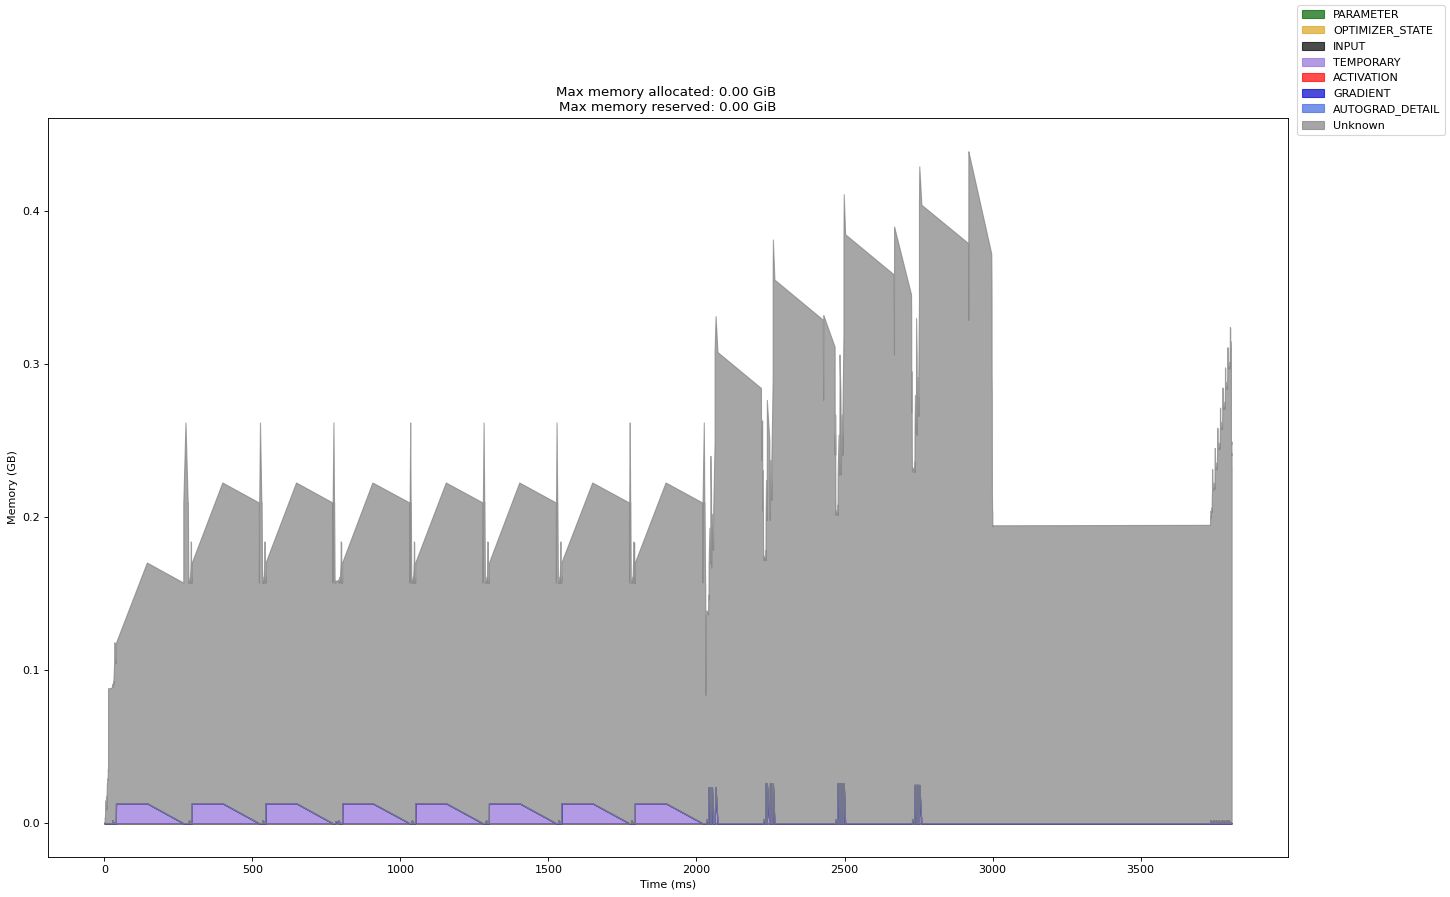

In [2]:
with profile(
    activities=[ProfilerActivity.CPU],
    profile_memory=True,
    record_shapes=True,
    with_stack=True,
) as prof:
    cube = get_cube(30)
    solution = cube.solve()

# Show memory allocation over time
prof.export_memory_timeline("memory.html")

# Export trace to Chrome Trace format (this can be opened in chrome://tracing or https://ui.perfetto.dev/)
prof.export_chrome_trace("trace.json")

In [3]:
# add @profile decorator to function to be profiled
cube = get_cube(20)
solution = cube.solve()

In [2]:
print("|  N  |     DOFs |  FWD Time |  BWD Time |   Peak RAM |")
print("| --- | -------- | --------- | --------- | ---------- |")

device = "cpu"
for N in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    mem_usage, result = memory_usage(
        lambda: subprocess.run(
            ["python", "cubes.py", "-N", str(N), "-device", device],
            capture_output=True,
            text=True,
        ),
        retval=True,
        include_children=True,
        max_usage=True,
        interval=0.1,
    )

    print(result.stdout.strip() + f" {mem_usage:8.1f}MB |")

|  N  |     DOFs |  FWD Time |  BWD Time |   Peak RAM |
| --- | -------- | --------- | --------- | ---------- |
|  10 |     3000 |     0.23s |     0.15s |    568.2MB |
|  20 |    24000 |     0.76s |     0.26s |    899.2MB |
|  30 |    81000 |     2.59s |     1.19s |   1442.7MB |
|  40 |   192000 |     7.35s |     3.78s |   2368.2MB |
|  50 |   375000 |    15.08s |     8.97s |   3935.7MB |
|  60 |   648000 |    27.47s |    18.87s |   4921.8MB |
|  70 |  1029000 |    46.57s |    33.96s |   5894.1MB |
|  80 |  1536000 |    76.04s |    57.84s |   6324.6MB |
|  90 |  2187000 |   121.45s |   109.08s |   7874.2MB |
